In [1]:
from proxy_methods_final import *
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import ttest_rel


/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#TODO: CHECK SOLVER

# Load data
---

In [3]:
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0

#Check for Nan values
print(index_data.isnull().sum())


AsOf          0
Batch         0
Tenor         0
Ticker        0
Series        0
Version       0
ConvSpread    0
dtype: int64


In [4]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_27130/1307506813.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


# Normal CSRA vs Community CSRA
---

In [5]:
# ticker = "AF" #Defined for the purposes of getting the liquid bucket (EVEN THOUGH WE USE THE INDEX)
# date = '2015-12-30'
# liquid_bucket = get_bucket(metadata, company_communities,ticker)[0]
# metadata_with_proxies = calculate_proxies_and_add_to_metadata(metadata, company_communities, prices_data, index_data, liquid_bucket, date)
# # metadata_with_proxies.to_csv('data/metadata_with_proxies.csv', index=False)

In [6]:
#Get matching dates in price data and index data
#-----------------------------------------
price_dates = prices_data.index.tolist()

#Extract date portion of the datetime object in the price data
index_dates = index_data['Date'].tolist()

matching_dates = [date for date in price_dates if date in index_dates]

In [7]:
len(prices_data.columns)

318

In [8]:
#NUM OF DATES
len(matching_dates)

2515

In [ ]:
tickers = prices_data.columns.to_list() #First 10 tickers

#ALEX DATES
#-----------
dates = matching_dates[0:839]

# #CALVIN DATES
# dates = matching_dates[839:1678] 

# #VINAYS DATES
# dates = matching_dates[1678:2515] 

proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)
proxy_time_series_df.to_csv('data/proxy_time_series_alex.csv', index=False)

In [10]:
#Return rows with Nan values
proxy_time_series_df[proxy_time_series_df.isnull().any(axis=1)]

,Ticker,Date,Actual_Spread,Proxy_Intersection,Proxy_Intersection_Community,Proxy_CSRA,Proxy_CSRA_Community


In [11]:
# #TROUBLESHOOTING
# #-----------------------------------------
# tickers = [prices_data.columns.to_list()[0]] #First ticker
# dates = matching_dates[0:1] #1 date
# # CALVIN: Changed calculate_proxy_time_series to use get_bucket to obtain bucket of respective ticker
# # define liquid bucket 
# # liquid_bucket = {
# #         'Sector': 'Financials',   
# #         'Country': 'United Kingdom',
# #         'Rating': 10
# #     }


# proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)
# proxy_time_series_df
# #-----------------------------------------

In [12]:
proxy_time_series_df

,Ticker,Date,Actual_Spread,Proxy_Intersection,Proxy_Intersection_Community,Proxy_CSRA,Proxy_CSRA_Community
0,AAUK,2010-09-14,179.666667,105.00,105.00,188.974433,127.596349
1,AAUK,2010-09-15,175.666667,105.58,105.58,188.816758,128.455915
2,AAUK,2010-09-16,174.666667,106.28,106.28,187.841680,126.075857
3,AAUK,2010-09-17,169.500000,106.96,106.96,185.686246,125.608172
4,AAUK,2010-09-20,171.833333,110.97,110.97,185.298630,125.807404
...,...,...,...,...,...,...,...
95,AF,2010-09-21,375.491763,109.85,109.85,131.056471,344.118582
96,AF,2010-09-22,381.500000,114.08,114.08,131.754695,349.228686
97,AF,2010-09-23,382.478975,116.68,116.68,136.003757,354.422028
98,AF,2010-09-24,390.138794,112.71,112.71,136.469680,346.787686


In [13]:
rmse_intersection_normal_list, rmse_intersection_communities_list, rmse_csra_normal_list, rmse_csra_communities_list = calculate_rmse_curves(proxy_time_series_df, dates)

In [14]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

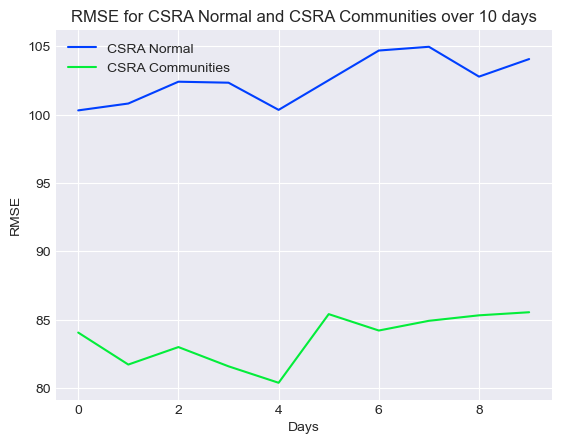

In [15]:
plot_rmse_curves(rmse_csra_normal_list, rmse_csra_communities_list, dates)

In [16]:
calculate_percentage_better(rmse_csra_normal_list, rmse_csra_communities_list)

Number of days where RMSE for normal CSRA method > RMSE for community CSRA method : 10
Percentage of days where CSRA Communities method is better: 100.0%


In [17]:
paired_t_test(rmse_csra_normal_list, rmse_csra_communities_list)

Shapiro-Wilk Test Statistic: 0.9315325021743774, p-value: 0.4631350636482239
CHECKING FOR NORMALITY OF DIFFERENCES
--------------------------------------
The differences appear to be normally distributed (fail to reject H0).
Since the differences are normally distributed, we can perform a paired t-test
PAIRED T-TEST RESULTS 
--------------------------------------
Paired T-Test Statistic: 39.07013604090177, p-value: 2.343267036836584e-11
Reject the null hypothesis for a one-tailed test: Method 1 has higher RMSE.
Therefore the average RMSE for the normal CSRA method is significantly greater than the average RMSE for the community CSRA method.
